### Import modules

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import ipywidgets as widgets
import io
import moviepy.editor as mpy
from PIL import Image
from scipy.ndimage.filters import gaussian_filter
import seaborn as sns

# Plotting style
plt.style.use('ggplot')
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# Not italized latex
matplotlib.rcParams['mathtext.default'] = 'regular'
matplotlib.rcParams["font.weight"] = "light"
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
%config InlineBackend.figure_format='retina'

# Define study
STUDY_NAME = "opt_flathv_75_1500_withBB_chroma15_b1891_octscan"


# Function to generate animations
def mpl_fig2array(plt):
    with io.BytesIO() as buffer:  # use buffer memory
        plt.savefig(buffer, format='png')
        buffer.seek(0)
        img = Image.open(buffer)
        return np.asarray(img)

### Load data

In [2]:
# Load dataframe
df = pd.read_parquet(f"../{STUDY_NAME}/da.parquet")

# Round all numbers to 3 decimals
df = df.round(3)

df


FileNotFoundError: [Errno 2] No such file or directory: '../opt_flathv_75_1500_withBB_chroma15_b1891_octscan/da.parquet'

In [3]:
# Reshape for plotting
df_to_plot = df.pivot(index="q1", columns="oct_current", values="normalized amplitude in xy-plane")
df_to_plot


NameError: name 'df' is not defined

### Plot heatmap for tune-tune scan

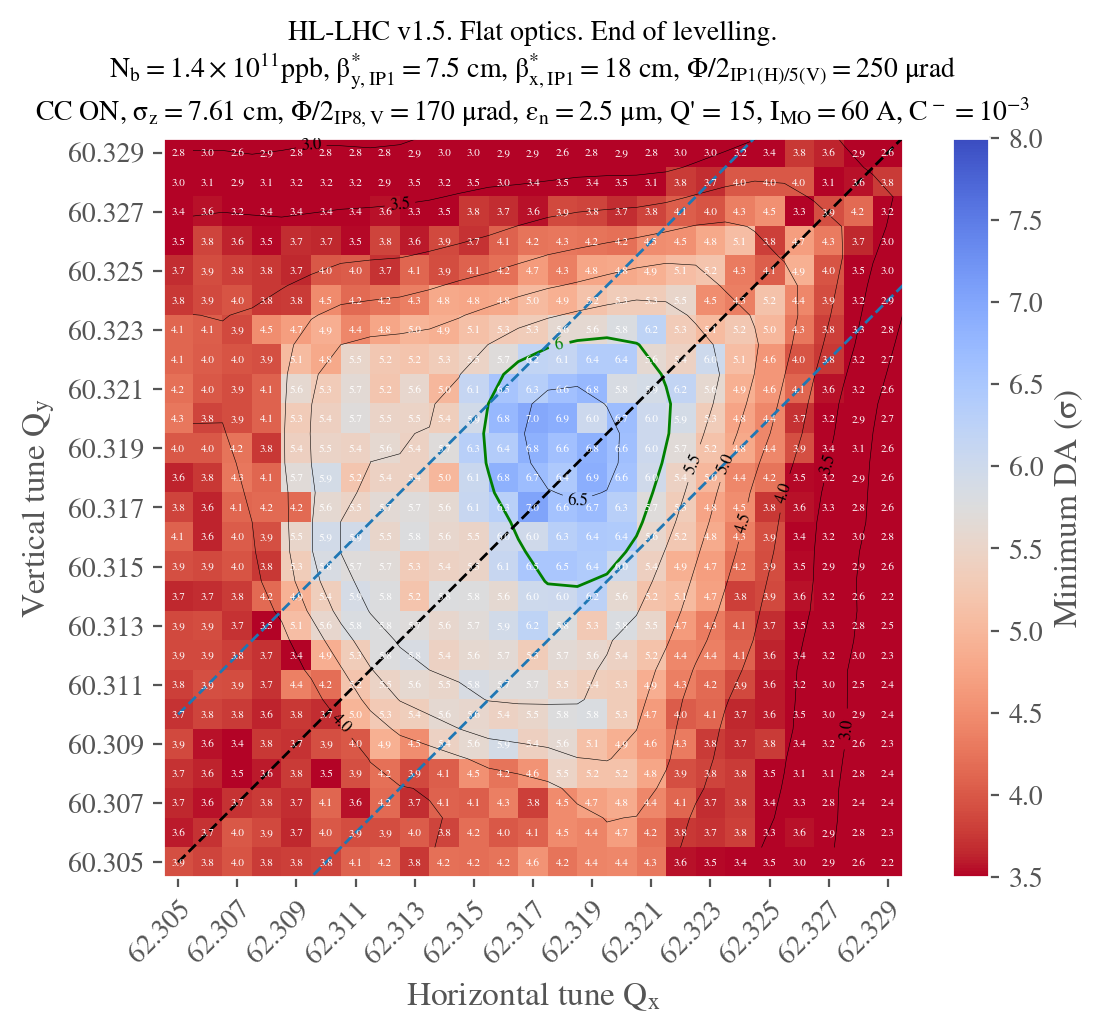

In [4]:
# Function to convert floats to scientific latex format
def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"${0} \times 10^{{{1}}}$".format(base, int(exponent))
    else:
        return float_str


def plot_heatmap(df_to_plot):
    # Get numpy array from dataframe
    data_array = df_to_plot.to_numpy()

    fig, ax = plt.subplots()
    im = ax.imshow(data_array, cmap="coolwarm_r", vmin=3.5, vmax=8)
    ax.invert_yaxis()

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(df_to_plot.columns))[::2], labels=df_to_plot.columns[::2])
    ax.set_yticks(np.arange(len(df_to_plot.index))[::2], labels=df_to_plot.index[::2])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(df_to_plot.index)):
        for j in range(len(df_to_plot.columns)):
            text = ax.text(
                j, i, f"{data_array[i, j]:.1f}", ha="center", va="center", color="w", fontsize=4
            )
            
    # Smooth data for contours
    data_smoothed = gaussian_filter(data_array, 1.0)

    # Plot contours
    CSS = ax.contour(
        np.arange(0.5, data_array.shape[1]),
        np.arange(0.5, data_array.shape[0]),
        data_smoothed,
        colors="black",
        levels=list(np.arange(3, 6, 0.5)) + list(np.arange(6.5, 10, 0.5)),
        linewidths=0.2,
    )
    ax.clabel(CSS, inline=True, fontsize=6)
    CS2 = ax.contour(
        np.arange(0.5, data_array.shape[1]),
        np.arange(0.5, data_array.shape[0]),
        data_smoothed,
        colors="green",
        levels=[6],
        linewidths=1,
    )
    ax.clabel(CS2, inline=1, fontsize=6)

    # ! Diagonal lines must be plotted after the contour lines, because of bug in matplotlib
    # Identity line
    ax.plot([0, 1000], [0, 1000], color="black", linestyle="--", linewidth=1)
    # plus minus 0.05 line (Q increment is 10**-3)
    ax.plot([0, 1000], [5, 1005], color="tab:blue", linestyle="--", linewidth=1)
    ax.plot([0, 1000], [-5, 995], color="tab:blue", linestyle="--", linewidth=1)

    ax.set_title(
        "HL-LHC v1.5. Flat optics. End of levelling."
        + "\n"
        + f"$N_b = $"
        + latex_float(df.nb.min())
        + "ppb, "
        + r"$\beta^{*}_{y,IP1} = 7.5$ cm"
        + ", "
        + r"$\beta^{*}_{x,IP1} = 18$ cm"
        + ", "
        + r"$\Phi/2_{IP1(H)/5(V)} = 250$ $\mu rad$"
        + "\n"
        + "CC ON, "
        + r"$\sigma_{z} = 7.61$ $cm$"
        + ", "
        + r"$\Phi/2_{IP8,V} = 170$ $\mu rad$"
        + ", "
        + r"$\epsilon_{n} = 2.5$ $\mu m$"
        + ", "
        + r"Q' = 15"
        + ", "
        + r"$Q_{y} = Q_{x} - 2 + 0.005 $"
        + ", "
        + r"$C^-=10^{-3}$",
        fontsize=10,
    )
    
    ax.set_ylabel("Current " + r"$I_{oct}(A)$")
    ax.set_ylabel("Horizontal tune " + r"$Q_x$")
    ax.set_xlim(0 - 0.5, data_array.shape[1] - 0.5)
    ax.set_ylim(0 - 0.5, data_array.shape[0] - 0.5)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Minimum DA (" + r"$\sigma$" + ")", rotation=90, va="bottom", labelpad=15)
    plt.grid(visible=None)
    plt.savefig("output_" + STUDY_NAME + ".pdf", bbox_inches="tight")
    plt.show()


plot_heatmap(df_to_plot)
